In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy as sc
import time
from functools import reduce

import tensorflow as tf
from tensorflow import keras

import rl_env

In [2]:
def create_environment(game_type='Hanabi-Full', num_players=2):
  """Creates the Hanabi environment.

  Args:
    game_type: Type of game to play. Currently the following are supported:
      Hanabi-Full: Regular game.
      Hanabi-Small: The small version of Hanabi, with 2 cards and 2 colours.
    num_players: Int, number of players to play this game.

  Returns:
    A Hanabi environment.
  """
  return rl_env.make(
      environment_name=game_type, num_players=num_players, pyhanabi_path=None)

In [3]:
def create_actor_model_NEW(num_actions, state_shape, num_units=512):
    x = tf.placeholder(tf.float32, shape=[None,state_shape], name='x')
    actions = tf.placeholder(tf.float32, shape=[None,num_actions], name='actions')
    
    h1 = tf.layers.dense(x, units=num_units, activation=tf.nn.relu)
    h2 = tf.layers.dense(h1, units=num_units, activation=tf.nn.relu)
    logits = tf.layers.dense(h2, units=num_actions, activation=None)
    y = tf.nn.softmax(logits)
    
    negative_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(labels=actions, logits=logits)
    #negative_log_prob = tf.losses.softmax_cross_entropy(onehot_labels=actions, logits=logits)
    #negative_log_prob = -tf.log(y)
    
    advantage = tf.placeholder(tf.float32, shape=[None,], name='advantage')
    
    loss = tf.reduce_mean(negative_log_prob*advantage)#tf.reduce_mean(tf.multiply(negative_log_prob, advantage))
    optimizer = tf.train.AdamOptimizer(0.1)
    train = optimizer.minimize(loss)
    
    return y, x, train, loss, advantage, actions

def create_critic_model(state_shape, num_units=512):
    model = keras.Sequential([
        keras.layers.Dense(num_units, input_dim=state_shape, activation=tf.nn.relu),
        keras.layers.Dense(num_units, activation=tf.nn.relu),
        keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error'])
    return model

In [4]:
def get_action(actor, state, legal_moves):
    policy = actor.predict(np.reshape(state, (1,-1))).squeeze()
    # somehow only consider the legal actions
    policy_legal = np.full(policy.shape, -np.inf)
    policy_legal[legal_moves] = policy[legal_moves]
    policy_legal = sc.special.softmax(policy_legal)
    
    action = np.random.choice(policy_legal.shape[0], p=policy_legal)
    logprob = np.log(policy_legal[action])
    
    return action, logprob

def get_action_NEW(sess, y, x, state, legal_moves):
    policy = sess.run(y, {x: [state]}).squeeze()
    # somehow only consider the legal actions
    policy_legal = np.full(policy.shape, -np.inf)
    policy_legal[legal_moves] = policy[legal_moves]
    policy_legal = sc.special.softmax(policy_legal)
    
    action = np.random.choice(policy_legal.shape[0], p=policy_legal)
    logprob = np.log(policy_legal[action])
    
    return action, logprob

def get_value_estimate(critic, state):
    return critic.predict(np.reshape(state, (1,-1))).squeeze()
    

In [6]:
def calculateRtsAndAts(rewards, baselines, gamma=0.95):
    Rts = []
    Ats = []
    
    for traj in range(len(rewards)):
        Rt = 0
        T = len(rewards[traj])
        Rts.append(np.zeros(T))
        Ats.append(np.zeros(T))
        for t in reversed(range(T)):
            Rt += rewards[traj][t]
            Rts[traj][t] = Rt
            At = Rt - baselines[traj][t]
            Ats[traj][t] = At
            
            Rt *= gamma
        
    return Rts, Ats

# Old O(n^2) version
def calculateRtsAndAts2(rewards, baselines, ep_lens, gamma=0.95):
    Rts = np.zeros(rewards.shape)
    Ats = np.zeros(rewards.shape)
    
    for traj in range(rewards.shape[0]):
        H = ep_lens[traj]
        for t in range(H):
            Rt = calculateSingleRt(rewards[traj, t:H], gamma)
            At = Rt -  baselines[traj, t]
            Rts[traj, t] = Rt
            Ats[traj, t] = At
            
    return Rts, Ats

def calculateSingleRt(rewards, gamma):
    rt = 0
    for t in range(len(rewards)):
        rt += gamma**(t)*rewards[t]
    return rt

In [ ]:
#actor = create_actor_model(env.num_moves(), env.vectorized_observation_shape()[0])
#critic = create_critic_model(env.vectorized_observation_shape()[0])
#actor.summary()
#critic.summary()

In [9]:
num_iterations = 1
num_trajectories = 1000
t0 = time.time()


for it in range(num_iterations):
    rewards = np.zeros((num_trajectories, 110))
    ep_lens = np.zeros(num_trajectories).astype(int)


    # collect trajectories
    for traj in range(num_trajectories):
        # reset environment
        observations = env.reset()
        reward = 0
        is_done = False

        # collect one trajectory
        for st in range(110):
            # extract legal moves and state from observations
            moves = observations['player_observations'][st % 2]['legal_moves_as_int']
            state = observations['player_observations'][st % 2]['vectorized']

            # get next action
            action, _ = get_action_NEW(sess, y, x, state, moves)

            # do next step
            observations, reward, is_done, _ = env.step(action)

            # store reward after executing action
            rewards[traj, st] = reward


            if (is_done or st == 110-1):
                ep_lens[traj] = st
                #print("Done", ep, st)
                #print(observations['player_observations'][0]['pyhanabi'])
                #print('reward', reward)
                #print(' --- ')
                break

    
t1 = time.time()
print(rewards.shape, ep_lens.shape, t1-t0)

(1000, 110) (1000,) 26.623703718185425


In [10]:
np.min(rewards, axis=1).mean()

-1.296

In [7]:
num_iterations = 500
num_trajectories = 50
t0 = time.time()

# create hanabi environment
env = create_environment()
# init simple keras critic 
critic = create_critic_model(env.vectorized_observation_shape()[0])
# init actor neural net (a custom tf graph)
y, x, train, loss, advantage, actions = create_actor_model_NEW(env.num_moves(), env.vectorized_observation_shape()[0])

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

losses = []
for it in range(num_iterations):
    if(it % 50 == 0):
        tt = time.time()
        print('iteration #', it, ', time passed: ', tt-t0)
    
    actions_ = [] 
    states = []
    rewards = []
    baselines = []
    logprobs = []
    ep_lens = []


    # collect trajectories
    for traj in range(num_trajectories):
        # reset environment
        observations = env.reset()
        reward = 0
        is_done = False
        actions_.append([])
        states.append([])
        rewards.append([])
        baselines.append([])
        logprobs.append([])

        # collect one trajectory
        for st in range(110):
            # extract legal moves and state from observations
            moves = observations['player_observations'][st % 2]['legal_moves_as_int']
            state = observations['player_observations'][st % 2]['vectorized']

            # get next action
            action, logprob = get_action_NEW(sess, y, x, state, moves)

            # store variables
            action_ = np.zeros(env.num_moves())
            action_[action] = 1
            actions_[traj].append(action_)
            states[traj].append(state)
            logprobs[traj].append(logprob)

            # get baseline(value estimate)
            baselines[traj].append(get_value_estimate(critic, state))

            # do next step
            observations, reward, is_done, _ = env.step(action)

            # store reward after executing action
            rewards[traj].append(reward)


            if (is_done or st == 110-1):
                ep_lens.append(st)
                #print("Done", ep, st)
                #print(observations['player_observations'][0]['pyhanabi'])
                #print('reward', reward)
                #print(' --- ')
                break

    # collected a bunch of trajectories, now calculate discounted rewards (Rts)
    Rts, Ats = calculateRtsAndNormalizedAts(rewards, baselines)
    # 'flatten' the lists
    x_train = np.array(reduce(lambda x,y: np.vstack((x,y)), states))
    adv = np.array(reduce(lambda x,y: np.hstack((x,y)), Ats))
    adv -= adv.mean()
    adv /= adv.std() + 10**-10
    rew = np.array(reduce(lambda x,y: np.hstack((x,y)), Rts))
    acts = np.array(reduce(lambda x,y: np.vstack((x,y)), actions_))
    
    # train critic and actor
    critic.train_on_batch(x_train, rew)
    rew -= rew.mean()
    rew /= rew.std() + 10**-10
    _, loss_t = sess.run((train, loss), {x: x_train, advantage: rew, actions: acts})
    losses.append(loss_t)
    
    
t1 = time.time()
print(len(rewards), len(ep_lens), len(losses), t1-t0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.dense instead.
iteration # 0 , time passed:  0.6457154750823975
Instructions for updating:
Use tf.cast instead.
iteration # 50 , time passed:  172.7711079120636
iteration # 100 , time passed:  325.59795570373535
iteration # 150 , time passed:  483.5095794200897
iteration # 200 , time passed:  648.0406601428986
iteration # 250 , time passed:  810.8260848522186
iteration # 300 , time passed:  965.7091994285583
iteration # 350 , time passed:  1114.8656842708588
iteration # 400 , time passed:  1270.396576166153
iteration # 450 , time passed:  1423.4461085796356
50 50 500 1575.7265634536743


In [ ]:
critic.predict(np.reshape(state, (1,-1))).squeeze()

In [ ]:
observations = env.reset()
state = observations['player_observations'][0]['vectorized']
critic.predict(np.reshape(state, (1,-1))).squeeze()

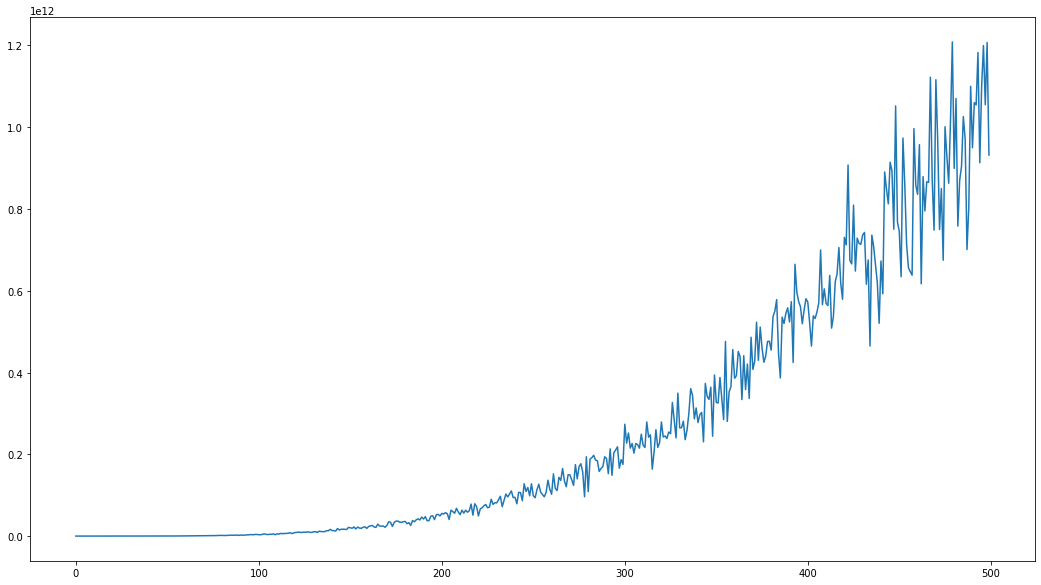

In [8]:
plt.figure(0, (18,10))
plt.plot(list(map(lambda x: -x,losses)))
plt.show()

In [ ]:
plt.figure(0, (18,10))
#plt.ylim((-100,60000))
plt.plot(list(map(lambda x: -x,losses)))
plt.show()

In [ ]:
batch_size = 4
truncated_backprop_length = 15
x = np.array(np.random.choice(2, 60, p=[0.5, 0.5]))

xx = x.reshape((batch_size, -1))
xxx = np.expand_dims(xx,-1)
print(x, x.shape)
print(xx, xx.shape)
print(xxx, xxx.shape)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
inputs_series = tf.unstack(batchX_placeholder, axis=1)

sess1 = tf.Session()
sess1.run(inputs_series, {batchX_placeholder: xx})